# libraries

In [22]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from collections import deque

# random seed for reproducibility
np.random.seed(42)

# Loading the Karate Club Graph
G = nx.karate_club_graph()

# layout for consistent visualization
pos = nx.spring_layout(G, seed=42)

print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")

Graph loaded: 34 nodes, 78 edges.


# Modularity Matrix 

In [23]:
def get_modularity_matrix(G):
    A = nx.to_numpy_array(G)
    k = A.sum(axis=1) 
    m = G.number_of_edges()
    k_k_T = np.outer(k, k)
    B = A - (k_k_T / (2 * m))
    return B

# Spectral Bisection

In [24]:
def spectral_split(B_sub, node_list):
    if len(node_list) < 2:
        return None, None, False

    # Eigenvalues and eigenvectors
    evals, evecs = la.eigh(B_sub)
    
    # Sorting
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]
    
    largest_eigenvalue = evals[0]
    leading_eigenvector = evecs[:, 0]
    
    # Stopping Criterion 1: Eigenvalue Threshold
    if largest_eigenvalue <= 1e-10: 
        return None, None, False
        
    # Split based on sign of eigenvector components
    group1 = []
    group2 = []
    
    for i, val in enumerate(leading_eigenvector):
        if val > 0:
            group1.append(node_list[i])
        else:
            group2.append(node_list[i])
    
    # Stopping Criterion 2: Trivial Partition
    if len(group1) == 0 or len(group2) == 0:
        return None, None, False
            
    return group1, group2, True

# Metrics (Centralities and coefficient) Calculation

In [25]:
def compute_metrics(G_current, iteration_idx, metrics_history):
    # Degree Centrality
    deg = nx.degree_centrality(G_current)
    
    # Betweenness Centrality 
    bet = nx.betweenness_centrality(G_current)
    
    # Closeness Centrality 
    clo = nx.closeness_centrality(G_current)
    
    # Clustering Coefficient 
    clus = nx.clustering(G_current)
    
    for node in G_current.nodes():
        metrics_history['degree'][node].append((iteration_idx, deg[node]))
        metrics_history['betweenness'][node].append((iteration_idx, bet[node]))
        metrics_history['closeness'][node].append((iteration_idx, clo[node]))
        metrics_history['clustering'][node].append((iteration_idx, clus[node]))

# Recursive Algorithm

Iteration 1: Splitting community of size 34 into 18 and 16


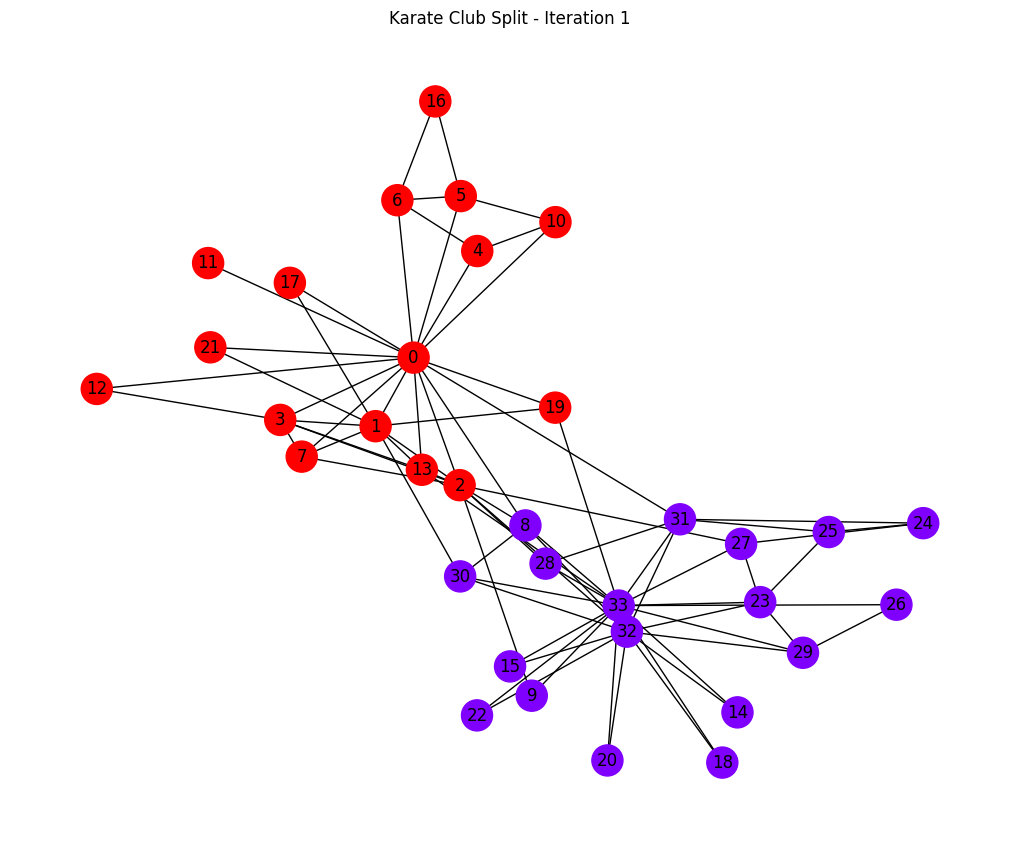

Iteration 2: Splitting community of size 18 into 12 and 6


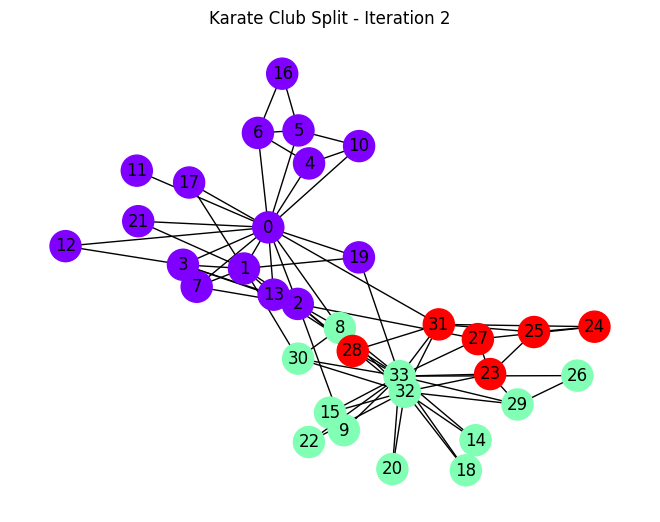

Iteration 3: Splitting community of size 16 into 8 and 8


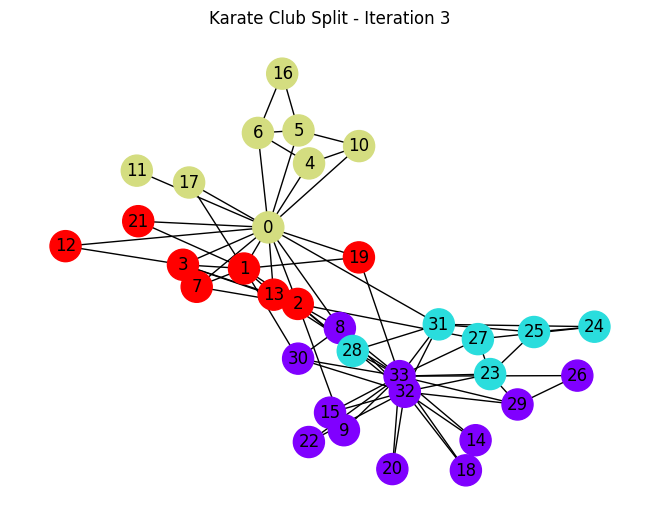

Iteration 4: Splitting community of size 12 into 2 and 10


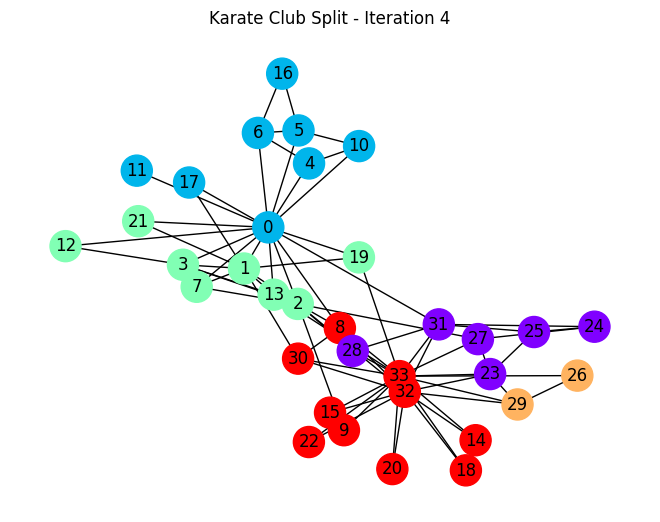

Iteration 5: Splitting community of size 6 into 4 and 2


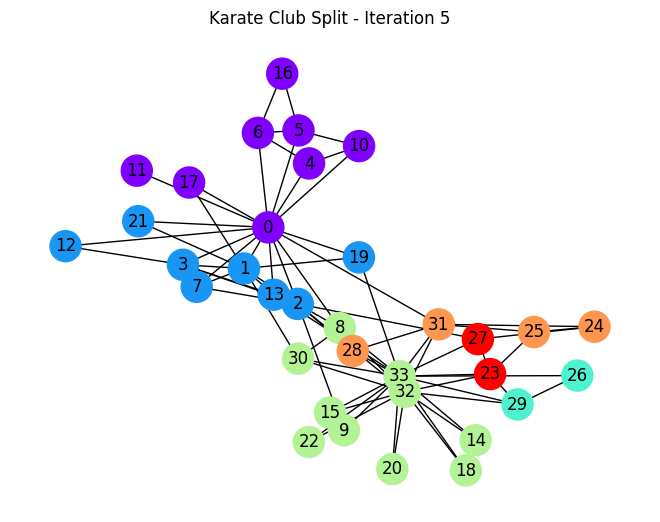

Iteration 6: Splitting community of size 8 into 3 and 5


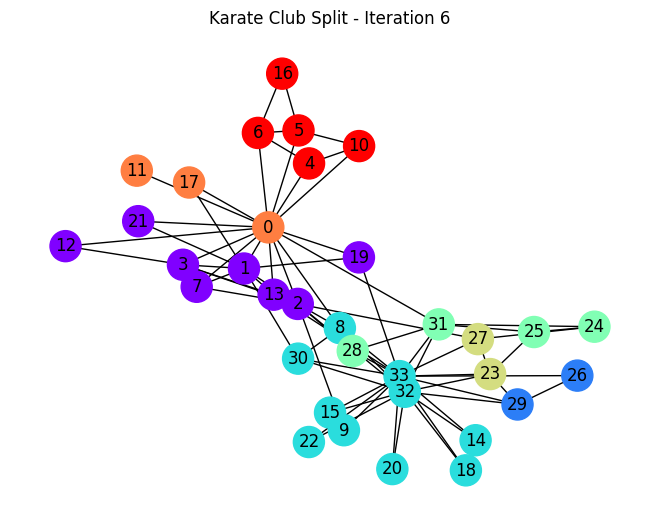

Iteration 7: Splitting community of size 8 into 4 and 4


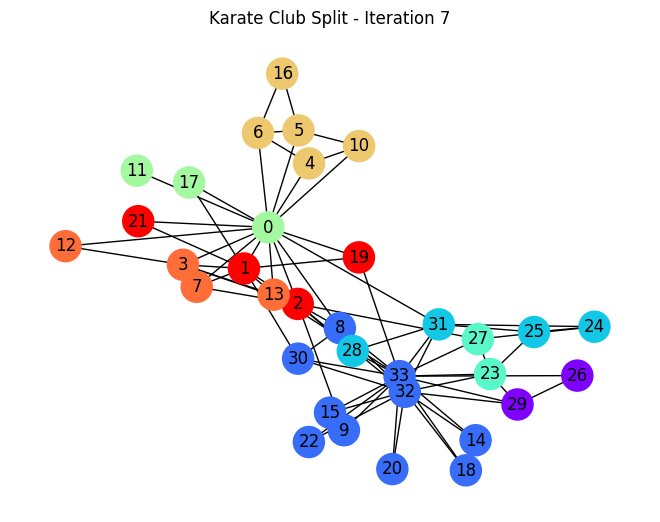

Iteration 8: Splitting community of size 10 into 2 and 8


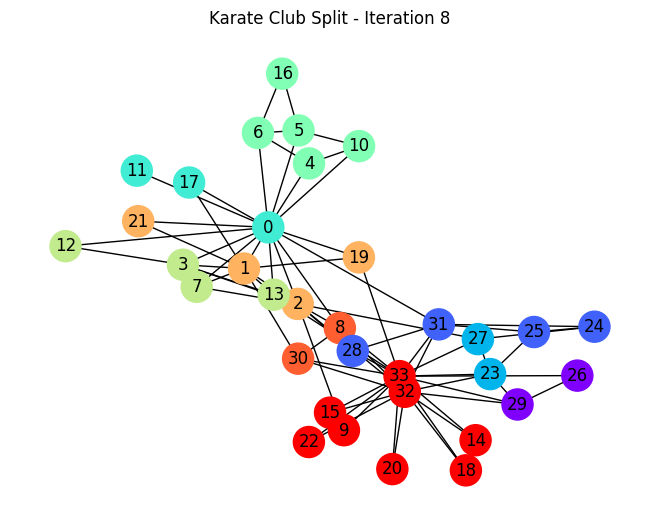

Iteration 9: Splitting community of size 4 into 1 and 3


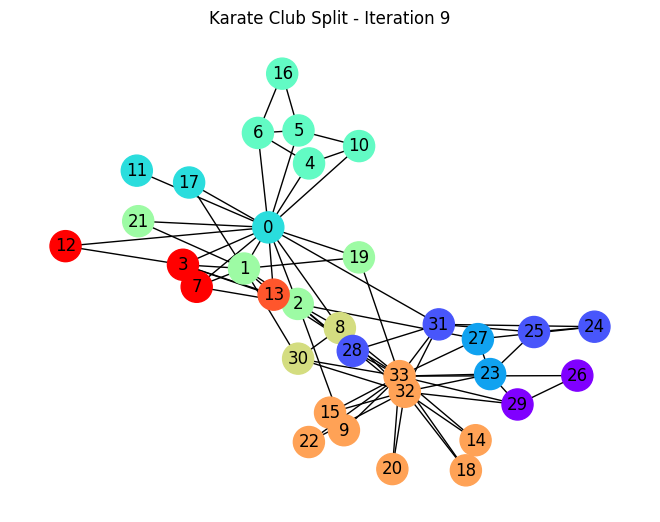

Iteration 10: Splitting community of size 4 into 3 and 1


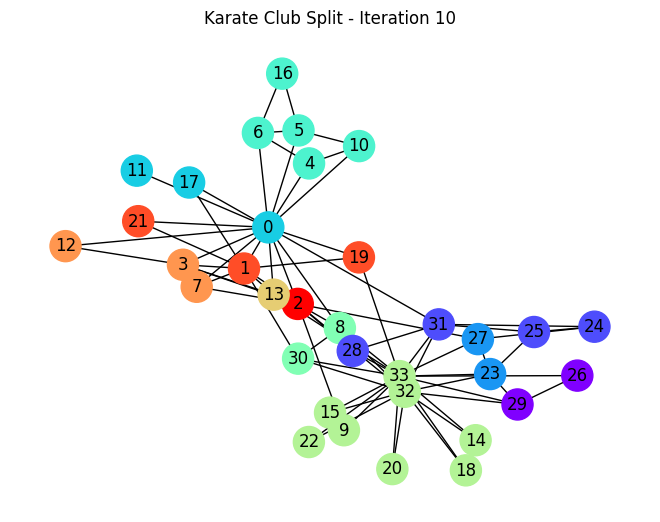

Iteration 11: Splitting community of size 8 into 5 and 3


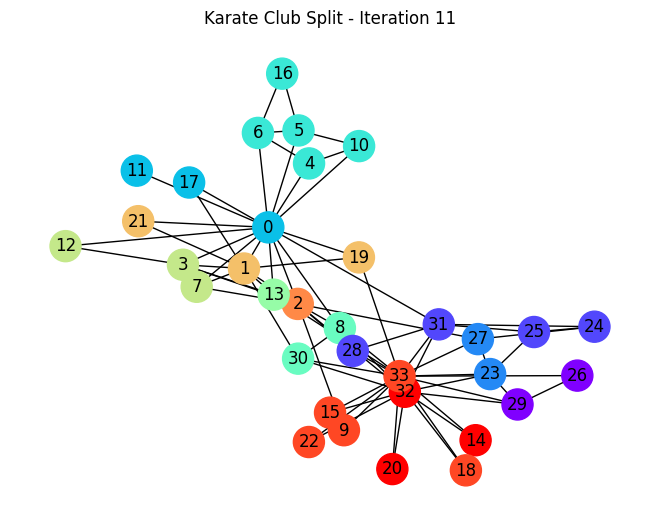

Iteration 12: Splitting community of size 5 into 1 and 4


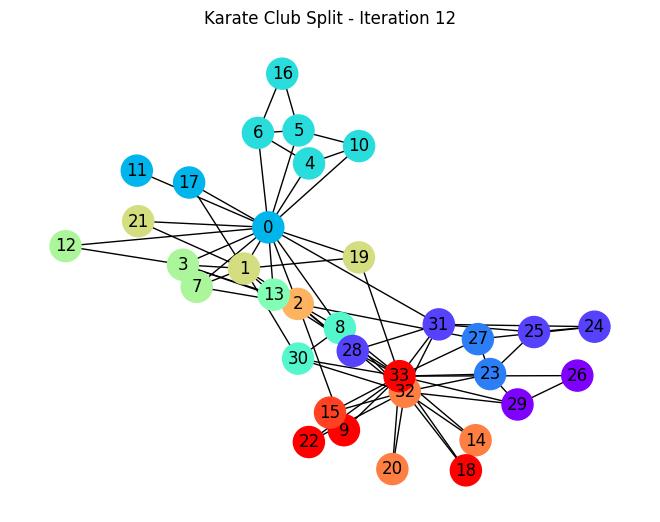


Algorithm converged. Found 13 communities.
Final Communities: [[26, 29], [24, 25, 28, 31], [23, 27], [0, 11, 17], [4, 5, 6, 10, 16], [8, 30], [13], [3, 7, 12], [1, 19, 21], [2], [14, 20, 32], [15], [9, 18, 22, 33]]


In [ ]:
# Initialize global B matrix once
B_global = get_modularity_matrix(G)
nodes_global = list(G.nodes())
node_to_idx = {n: i for i, n in enumerate(nodes_global)}

# Queue for BFS-style recursion
communities = [nodes_global]
queue = deque([nodes_global])

# metrics history
metrics_history = {
    'degree': {n: [] for n in G.nodes()},
    'betweenness': {n: [] for n in G.nodes()},
    'closeness': {n: [] for n in G.nodes()},
    'clustering': {n: [] for n in G.nodes()}
}

iteration = 0
final_partition = []

plt.figure(figsize=(10, 8))

# Initial Metrics (iteration 0)
compute_metrics(G, iteration, metrics_history)
iteration += 1

while queue:
    current_community_nodes = queue.popleft()
    current_indices = [node_to_idx[n] for n in current_community_nodes]
    B_sub = B_global[np.ix_(current_indices, current_indices)]
    g1, g2, split_success = spectral_split(B_sub, current_community_nodes)
    
    if split_success:
        print(f"Iteration {iteration}: Splitting community of size {len(current_community_nodes)} into {len(g1)} and {len(g2)}")
        queue.append(g1)
        queue.append(g2)
        communities.remove(current_community_nodes)
        communities.append(g1)
        communities.append(g2)
        
        # Visualization
        plt.clf()
        color_map = []
        # Create a map of node
        partition_map = {}
        for idx, comm in enumerate(communities):
            for node in comm:
                partition_map[node] = idx
        
        node_colors = [partition_map.get(n, 0) for n in G.nodes()]
        
        nx.draw(G, pos, node_color=node_colors, with_labels=True, cmap=plt.cm.rainbow, node_size=500)
        plt.title(f"Karate Club Split - Iteration {iteration}")
        plt.show()
        
        # Metric Evolution
        G_temp = G.copy()
        edges_to_remove = []
        for u, v in G.edges():
            if partition_map[u] != partition_map[v]:
                edges_to_remove.append((u, v))
        G_temp.remove_edges_from(edges_to_remove)
        
        compute_metrics(G_temp, iteration, metrics_history)
        
        iteration += 1
        
    else:
        # No split possible, final community
        final_partition.append(current_community_nodes)

# Add any remaining communities
while queue:
    final_partition.append(queue.popleft())

print(f"\nAlgorithm converged. Found {len(final_partition)} communities.")
print("Final Communities:", final_partition)

# Plotting Metric Evolution

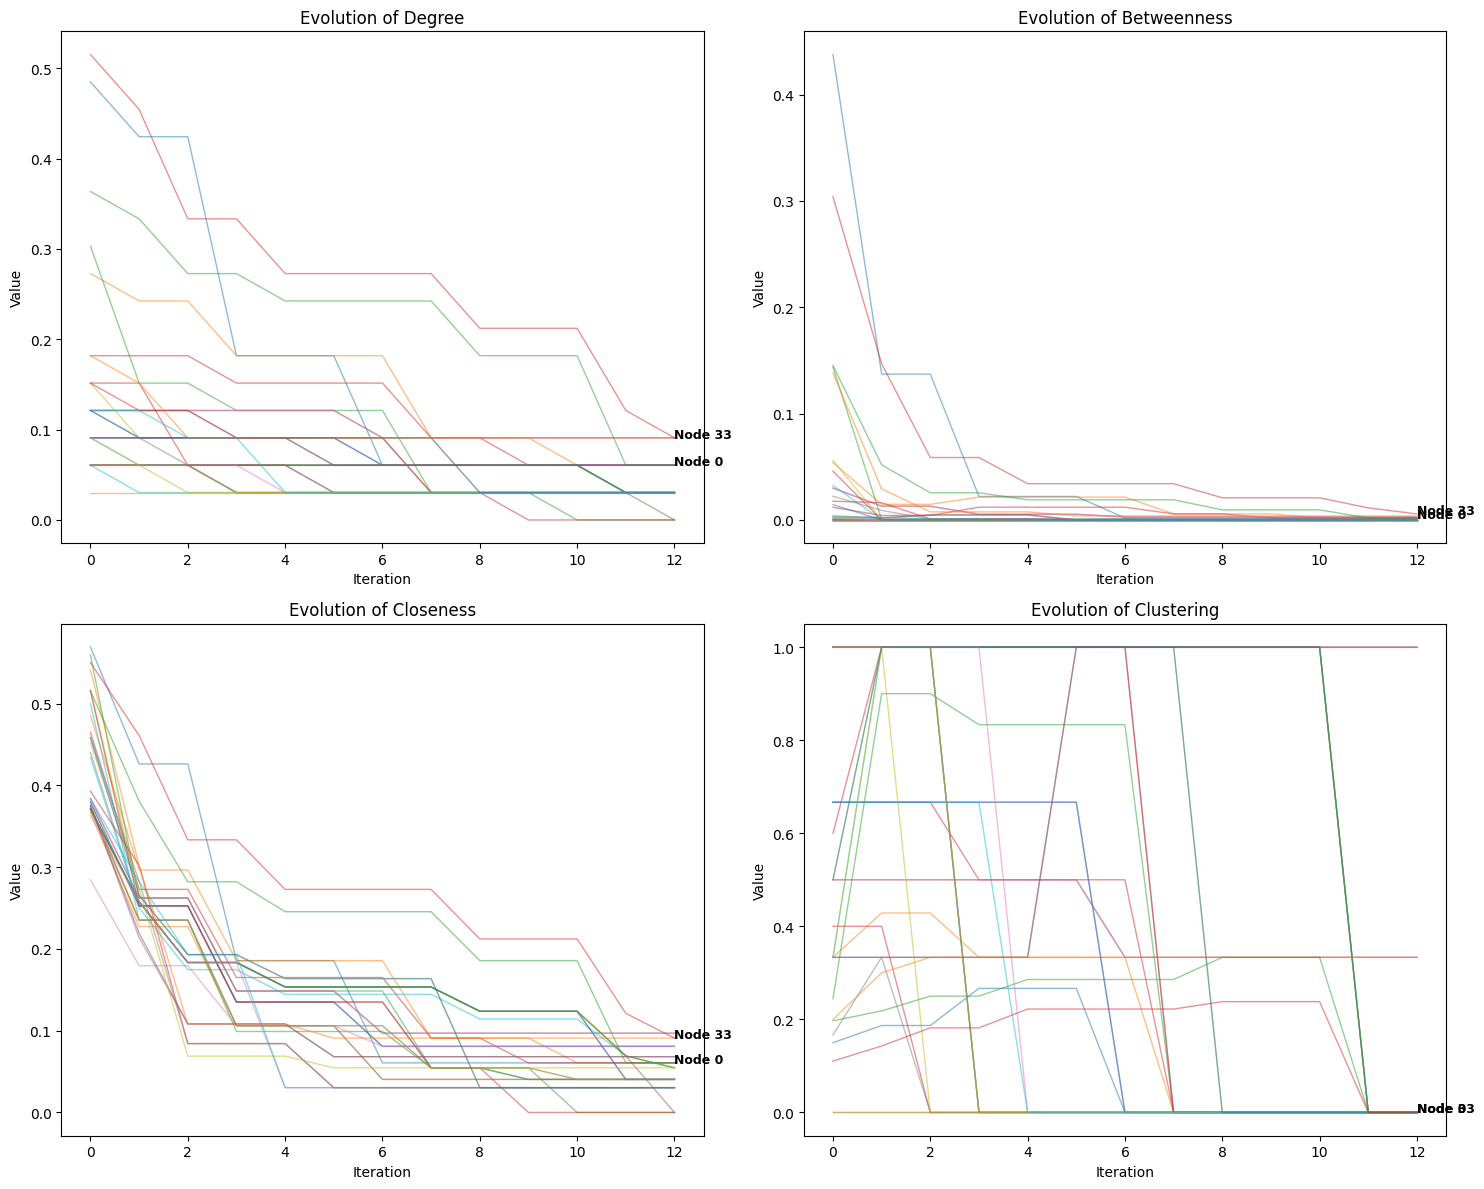

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metric_names = ['degree', 'betweenness', 'closeness', 'clustering']

for i, ax in enumerate(axes.flat):
    m_name = metric_names[i]
    ax.set_title(f"Evolution of {m_name.capitalize()}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Value")
    
    # Ploting a line for each node
    for node in G.nodes():
        data = metrics_history[m_name][node]
        if data:
            x_vals, y_vals = zip(*data)
            ax.plot(x_vals, y_vals, alpha=0.5, linewidth=1)
            
            # Labelling nodes 0 and 33
            if node == 0 or node == 33:
                ax.text(x_vals[-1], y_vals[-1], f"Node {node}", fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Discussion 

## Node 0 and Node 33 
#### Just as the "Karate Club Story" suggests, Node 0 (the instructor) and Node 33 (the president) clearly emerge as the anchors of the network. My plots for Degree and Closeness Centrality show that these two nodes consistently maintain the highest values throughout every iteration. This confirms that even as the network fractures into smaller pieces, these two individuals act as the gravitational centers or local hubs holding their respective factions together.

## Bridge Collapse
#### The Betweenness Centrality plot reveals a fascinating phase transition. Initially, Nodes 0 and 33 have massive peaks, indicating they are the primary "bridges" controlling information flow between the rival groups. However, immediately after the first split (Iteration 1), these values collapse sharply. This proves that their high initial influence was derived from their position between the communities; once that link is severed, they transition from global brokers to purely local leaders

## Clustering Coefficient
#### Conversely, the Clustering Coefficient plot shows an upward trend, with many nodes spiking to a value of 1.0. This indicates that as the algorithm removes the "noisy" edges connecting different groups, the remaining communities become incredibly tight-knit. Essentially, the algorithm successfully isolates "cliques" where every member is connected to every other member, validating that the detected communities are socially cohesive.

## Summary
#### Overall, the results highlight a clear distinction between global and local influence. Nodes at the boundaries (like 0 and 33) dominate global metrics like Betweenness only when the graph is fully connected. As the community structure is revealed, global influence is traded for local cohesion, demonstrating that the spectral method successfully recovers the "ground truth" split by identifying the fault lines where these global bridges exist

##### Made by Raboob Rahma K P (IMS24179)
###### Acknowledgment of AI Assistance: Generative AI tools were used to assist in the code structure, syntax and debugging. All outputs and logic were verified by myself.